# ARIMA - SARIMA

Não vou utilizar ARIMA ou SARIMA para fazer previsões sérias, é mais para aprender algumas técnicas e como separar os dataset de teste e treino.

# Ìndice

1. [Resumo e objetivos](#Resumo-e-objetivos)
- [Série temporal básica](#Série-temporal-básica)
    - [O que é estacionaridade?](#O-que-é-estacionaridade?)
    - [Checando estacionaridade](#Checando-estacionaridade)
    - [Transformando em uma série estacionária](#Transformando-em-uma-série-estacionária)
    - [Separando o dataset](#Separando-o-dataset)
- [Série temporal](#Série-temporal)
    - [ARIMA](#ARIMA)
    - [SARIMA](#SARIMA)
- [Apéndice](#Apéndice) 
    - [O que é a hipótese nula e como é utilizado no ADF teste](#null)
    - [O andar do bêbado](#O-andar-do-bêbado)
- [Referências](#Referências)

Explicar:
- [x] O que é estacionaridade?
- [ ] Suavização das curvas (Explicar como cada uma ajuda na estacionaridade)
    - [ ] Exponencial
    - [ ] Moving Averange
    - [ ] Transformação
- [ ] Tedência e sazonalidade
    - [ ] Lagged Plot
    - [ ] Retirando Trend e Seasonality
        - [ ] diff (trend)
        - [ ] diff (season)
        - [ ] Decomposição Clássica
- [ ] Checando a estacionaridade
    - [ ] Null hypothesis
    - [ ] ADF teste
    - [ ] KSPP teste
    - [ ] Residual Error
- [ ] Série temporal
    - [ ] Random Walk
    - [ ] ACF e PACF
    - [ ] ARIMA
    - [ ] SARIMA
    - [ ] Forecasting
    - [ ] Erro de forecasting
        - [ ] Porcentagem do erro de forecasting
        - [ ] Distribuição gaussiana
            - [ ] Usar o ACF
            - [ ] Olhar para o histograma
        - [ ] Ljung-Box
    - [ ] Erro entre modelos
        - [ ] AIC
        - [ ] SIC
        
- [A Gentle Introduction to Handling a Non-Stationary Time Series in Python](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/)

# Resumo e objetivos

Tentei simplificar o máximo que consegui, mas o assunto é complicado para quem não tem uma base matemática boa.



[2]: https://www.quantstart.com/articles/Serial-Correlation-in-Time-Series-Analysis

Começar com:
- https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
- https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
- https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

# Carregando os arquivos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller

from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from statsmodels.tsa.seasonal import seasonal_decompose

path = 'data'

train = pd.read_csv(path + '/sales_train.csv.gz')
test = pd.read_csv(path + '/test.csv.gz').set_index('ID')
items = pd.read_csv(path + '/items.csv')
items_cat = pd.read_csv(path + '/item_categories.csv')
shops = pd.read_csv(path + '/shops.csv')
geo = pd.read_csv(path + '/geo_shop.csv')

# Série temporal básica

- [O que é estacionaridade?](#O-que-é-estacionaridade?)
- [Checando estacionaridade](#Checando-estacionaridade)
- [Transformando em uma série estacionária](#Transformando-em-uma-série-estacionária)
- [Separando o dataset](#Separando-o-dataset)
- [Considerações finais](#Considerações-finais)

### O que é estacionaridade?

[Artigo básico][1] [Artigo complexo][2] [ML][3]

[1]: https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
[2]: https://www.quantstart.com/articles/Serial-Correlation-in-Time-Series-Analysis
[3]: https://machinelearningmastery.com/time-series-data-stationary-python/

Uma série estritamente estacionária é uma série que não varia com o tempo, ou seja, sua média, variância e convariância não dependem do tempo. A série abaixo é estritamente estacionária:

![non-stationary](stat.png)

O que provavelmente não vai acontecer no mundo real, em geral temos que fazer varios ajustes para que a série se torne estacionária. Os gráficos abaixo mostram séries **não** estacionárias:

![non-stationary](non-stat.png)

1. O primeiro gráfico apresenta uma tendência de subida, portante sua média varia com o tempo.
2. O segundo gráfico apresenta uma dispersão maior com o passar do tempo. Então os máximos e minímos da função variam com o tempo, assim como sua variância.
3. O terceiro gráfico apresenta mais de um padrão de repetição, temos oscilações mais curtas e mais longas dependendo do tempo. Esse tipo de padrão é característicos de uma convariância dependente do tempo.

Essas figuras foram retiradas desse [site][1], que parece ter bastante coisa sobre séries temporais.

[1]: https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

### Escolhendo uma loja

Este dataset não é muito bom para se fazer análises temporais porque estamos interessados na previsão de vendas no mês e só temos 34 meses. Séries temporais mais adquedas podem ser encontradas nestes kerneis: 
   - [Co2 Emission Forecast ARIMA](https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima)
   - [Climate Change Forecast SARIMA](https://www.kaggle.com/leandrovrabelo/climate-change-forecast-sarima-model?utm_medium=email&utm_source=intercom&utm_campaign=datanotes-2019)
   
As análises vão ser feitas para uma única loja e vamos utilizar o número de itens vendidos por mês. Abaixo eu reuno o dataset todo e escolho a loja 37, ela tem uma quantidade de vendas razoáveis e parece não ser estacionária. Vou deixar abaixo uma imagem do dataset do primeiro kernel indicado, só para questão de comparação com o dataset que vamos utilizar aqui.

<img src="real_non-stat.png" alt="alt text" width="800" height="100">

In [3]:
# Unindo o dataset.
train_full = pd.merge(train, items, on='item_id', how='left')
train_full = pd.merge(train_full, items_cat, on='item_category_id', how='left')
train_full = pd.merge(train_full, shops, on='shop_id', how='left')
train_clean = train_full.drop(['date', 'item_name', 'shop_name', 'item_category_name'], axis=1)
train_clean['revenue'] = train_full['item_cnt_day'] * train_full['item_price']

In [4]:
# Agrupando por mês.
df = train_clean.pivot_table(index=['shop_id'], 
                             columns=['date_block_num'],
                             values=['item_cnt_day'],
                             aggfunc='sum', fill_value=0)

df.columns = df.columns.droplevel(0)

# Array com o número de meses:
months = train_clean['date_block_num'].nunique()

# Datas para serem colocadas no eixo x:
date_range = pd.date_range(start='1/2013', periods=months, freq='M')
date_range = [ str(date_range.year[month]) + '/' + str(date_range.month_name()[month]) for month in range(months)]

In [5]:
# Loja 37 é uma boa escolha.
shop = 37

items_sold = df.loc[shop, :]

In [6]:
trace1 = go.Scatter(
    x=date_range,
    y=items_sold,
    name='shop ' + str(shop),
)
fig = tools.make_subplots(rows=1, cols=1)

fig.append_trace(trace1, 1, 1)

fig['layout'].update(height=500, width=900, title='Nº de itens vendidos por mês',
                     xaxis = dict())
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



> Os dois datasets são bem diferentes.

Note que a série que vamos estudar possui uma tendência de queda nas vendas, a variância assume valores diferentes com o tempo e com certeza vai ter uma sazonalidade, i.e., vamos ver mais vendas nos meses de dezembro por causa do natal. Tudo isso torna a série não estacionária e podemos utilizar vários métodos para tentar corrigir isso.

### Suavização de séries

Existem diversos métodos para tornarmos uma série temporal mais suave e bem comportada, o que pode ajudar muito no controle da variância.

    - [ ] Exponencial
    - [ ] Moving Averange
    - [ ] Transformação

### Checando estacionaridade

Nem sempre vai ser possível checar no olho se a série é estacionária ou não. Precisamos utilizar alguns testes matemáticos para isso, então vamos pegar uma loja do dataset e fazer algumas analizes. 

> Esse dataset não é muito bom para fazer esse tipo de coisa, ele é muito simples e tem poucos pontos. Eu deixei nas referências dois kerneis com dataset melhores para isso.

Vou unir o dataset todo, escolher uma loja e fazer todas as análies e previsões com o número de itens vendidos.

#### ADF (Augmented Dickey Fuller) Test

Criei uma função porque vou utilizar muito esse teste.

In [6]:
# Função para fazer o teste e mostrar os resultados.

def adf_teste(time_series, regression, maxlag=0):
    #Fazendo o teste.
    adf_test = adfuller(items_sold, regression=regression, maxlag=maxlag, autolag=None)

    # Arrumando as variáveis para o print.
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value',
                                                 '#Lags Used',
                                                 'Number of Observations Used'])
    for percent, value in adf_test[4].items():
        
        adf_output['Critical Value (%s)' % percent] = value
        
    print('Resultados ADF: \n')
    print(adf_output)

Para que a série seja estacionária, é preciso que o p-value seja menor que $0.05$ ($5\%$). Deixei uma explicação mais complexa sobre os motivos disso no [apêndice](#Apêndice).

In [7]:
adf_teste(items_sold, 'c', maxlag=0)

Resultados ADF: 

Test Statistic                 -2.658821
p-value                         0.081439
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


Como já era esperado, a série não é estacionária.

### Transformando em uma série estacionária

 Algumas transformações simples podem fazer uma série se tornar estacionária. Em geral elas tentam retirar a tendência da série ou alguma sazonalidade. No caso desse dataset, provavelmente temos as duas, a tendência de queda no número de itens vendidos e as vendas de natal.

#### Log

As vezes aplicando o $ln$ na série é suficiente para ela se tornar estacionária.

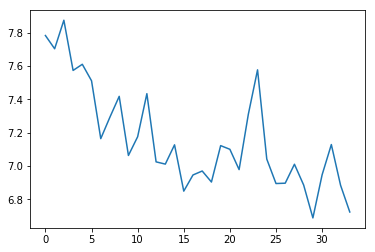

In [8]:
plt.plot(np.log(items_sold))
plt.show()

> Ainda tem uma tendência de queda.

#### Rolling window

Essa técnica serve para suavizar o gráfico e diminuir a variância. Para isso são feitas médias dos valores da seguinte forma $Y_{med} = \frac{(Y_t + Y_{t-1})}{2}$, neste caso estamos considerando uma janela de tamanho $2$, ou seja, pegando dois valores próximos e tirando a média.

In [9]:
window_size = 2

items_sold_smoothed = items_sold.rolling(window = window_size).mean()

In [10]:
items_sold.head()

date_block_num
0    2399
1    2216
2    2629
3    1946
4    2019
Name: 37, dtype: int64

In [11]:
items_sold_smoothed.head()

date_block_num
0       NaN
1    2307.5
2    2422.5
3    2287.5
4    1982.5
Name: 37, dtype: float64

> Como não temos dados anteriores ao primeiro valor, ele é sustituido por NaN.

Gráfico comparando a série original e após o rolling window.

In [12]:
window_size = 2
items_sold_smoothed = items_sold.rolling(window = window_size).mean()

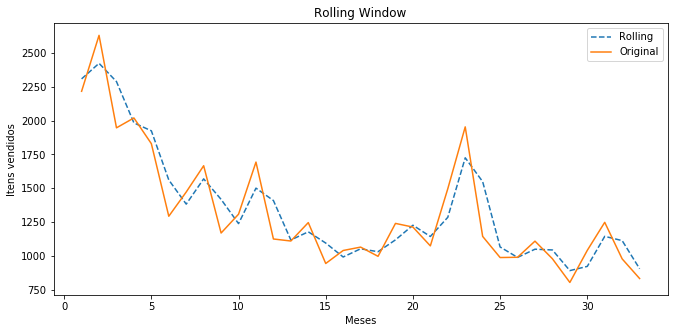

In [13]:
fig, ax1 = plt.subplots(1, figsize=(11,5))

ax1.set_title('Rolling Window')

ax1.plot(items_sold_smoothed, linestyle='--', label='Rolling')
ax1.plot(items_sold[window_size-1:], label='Original')
ax1.set_ylabel('Itens vendidos')
ax1.set_xlabel('Meses')
ax1.legend()

plt.show()

> **Obs.:**
- Repare que a série fica bem mais suave, isso pode ser bom ou ruim, no fim das contas podemos perder informação se escolhermos uma janela muito grande.
- Essa técnica é uma suavização linear, porque considera os pontos próximos como tendo o mesmo peso.

> Ainda tem uma tendência de queda.

#### Peso exponencial

In [14]:
items_sold.head()

date_block_num
0    2399
1    2216
2    2629
3    1946
4    2019
Name: 37, dtype: int64

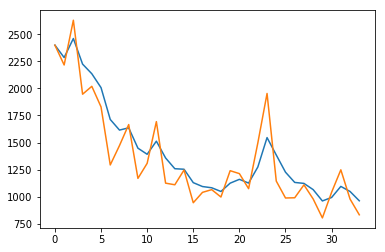

In [15]:
a = items_sold.ewm(alpha=0.4).mean()
plt.plot(a)
plt.plot(items_sold)
plt.show()

#### Diferenciando

Diferenciar uma série é fazer $Y_{dif} = Y_t - Y_{t-1}$, neste caso a diferença é só com o primeiro termo, é possível utilizar mais.

In [16]:
dif = 1
items_sold_diff = items_sold.diff(dif).dropna(axis=0)

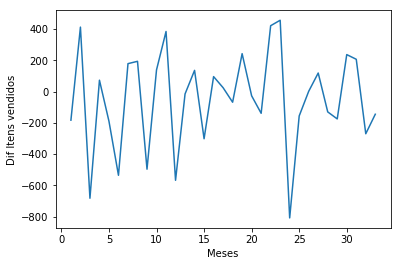

In [17]:
figure, ax1 = plt.subplots(1)

ax1.plot(items_sold_diff)

ax1.set_ylabel('Dif Itens vendidos')
ax1.set_xlabel('Meses')

plt.show()

- Adicionar o exponencial smooth.

#### Decompondo a série

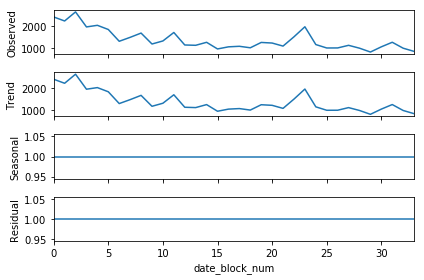

In [31]:
result = seasonal_decompose(items_sold, freq=1, model='multiplicative')
result.plot()
plt.show()

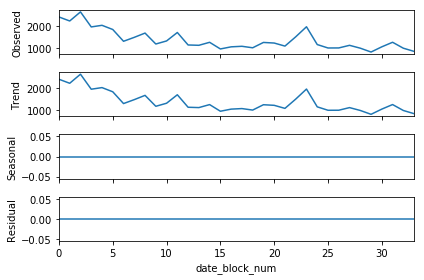

In [30]:
result = seasonal_decompose(items_sold, freq=1, model='adtive')
result.plot()
plt.show()

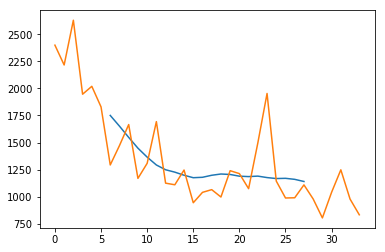

In [49]:
plt.plot(items_sold - result.seasonal - result.resid)
plt.plot(items_sold)

### Separando o dataset

### Considerações finais

# Série temporal

   - [Random Walk](#Random-walk)
   - [ARIMA](#ARIMA)
   - [SARIMA](#SARIMA)
   - [Considerações finais](#Considerações-finais)

### Random walk

- Falar o que é o resíduo e com ele é relacionada a um ruído branco.
    - Mostrar uma guassiana de um ruído branco. média e desvio padrão.
    - Comparar com o encontrado.

### ARIMA

### SARIMA

### Considerações finais

# Apéndice

### O que é a hipótese nula e como é utilizado no ADF teste

Show off:

1. Explicar o teste ADF de verdade:
    
    - Explicar de forma geral o que é a hipótese nula e dar o exemplo dos dados.
    - Explicitar como o p-value ajuda na inferência da hipótese.
    - Começar assumindo o random walk, sem dar muito explicação.
    - Falar da raíz unitária, sem dar muita explicação.
    - Aplicar ao teste ADF a Null hypothesis e definir qual é a nossa hipótese.
    - Explicar o p-value.

- Null hypothesis ($H_0$): Existe uma raiz unitária, indicando que a série não é estacionária.
- Alternate Hypothesis ($H_1$): Não existe uma raiz unitária, indicando que a série é estacionária.

>Se minha hipótese $H_0$ é falsa então $H_1$ é obrigatoriamente verdadeira.

**p-value** é a probabilidade do evento ocorrer.

- Se p-value < 5% o evento é pouco provável, ou seja, podemos considerar que não ocorre.

O que queremos mostrar é que, olhando para os dados que temos, $H_0$ é pouco provável que aconteça, logo $H_1$ é acotence.

livro https://www.stata.com/manuals13/tsdfuller.pdf

https://en.wikipedia.org/wiki/P-value#cite_note-7
The p-value is used in the context of null hypothesis testing in order to quantify the idea of statistical significance of evidence.[note 1] Null hypothesis testing is a reductio ad absurdum argument adapted to statistics. In essence, a claim is assumed valid if its counter-claim is improbable.

As such, the only hypothesis that needs to be specified in this test and which embodies the counter-claim is referred to as the null hypothesis (that is, the hypothesis to be nullified). A result is said to be statistically significant if it allows us to reject the null hypothesis. That is, as per the reductio ad absurdum reasoning, the statistically significant result should be highly improbable if the null hypothesis is assumed to be true. The rejection of the null hypothesis implies that the correct hypothesis lies in the logical complement of the null hypothesis. However, unless there is a single alternative to the null hypothesis, the rejection of null hypothesis does not tell us which of the alternatives might be the correct one.


The smaller the p-value, the higher the significance because it tells the investigator that the hypothesis under consideration may not adequately explain the observation. The null hypothesis {\displaystyle H} H is rejected if any of these probabilities is less than or equal to a small, fixed but arbitrarily pre-defined threshold value {\displaystyle \alpha } \alpha , which is referred to as the level of significance.

**One roll of a pair of dice**
Suppose a researcher rolls a pair of dice once and assumes a null hypothesis that the dice are fair, not loaded or weighted toward any specific number/roll/result; uniform. The test statistic is "the sum of the rolled numbers" and is one-tailed. The researcher rolls the dice and observes that both dice show 6, yielding a test statistic of 12. The p-value of this outcome is 1/36 (because under the assumption of the null hypothesis, the test statistic is uniformly distributed) or about 0.028 (the highest test statistic out of 6×6 = 36 possible outcomes). If the researcher assumed a significance level of 0.05, this result would be deemed significant and the hypothesis that the dice are fair would be rejected.

In this case, a single roll provides a very weak basis (that is, insufficient data) to draw a meaningful conclusion about the dice. This illustrates the danger with blindly applying p-value without considering the experiment design.

### O andar do bêbado

Explicar o random walk

https://www.stata.com/manuals13/tsdfuller.pdf
- Pure Random Walk (Yt = Yt-1 + εt ) Random walk predicts that the value at time "t" will be equal to the last period value plus a stochastic (non-systematic) component that is a white noise, which means εt is independent and identically distributed with mean "0" and variance "σ²." Random walk can also be named a process integrated of some order, a process with a unit root or a process with a stochastic trend. It is a non-mean-reverting process that can move away from the mean either in a positive or negative direction. Another characteristic of a random walk is that the variance evolves over time and goes to infinity as time goes to infinity; therefore, a random walk cannot be predicted.
- Random Walk with Drift (Yt = α + Yt-1 + εt ) If the random walk model predicts that the value at time "t" will equal the last period's value plus a constant, or drift (α), and a white noise term (εt), then the process is random walk with a drift. It also does not revert to a long-run mean and has variance dependent on time.
- Deterministic Trend (Yt = α + βt + εt ) Often a random walk with a drift is confused for a deterministic trend. Both include a drift and a white noise component, but the value at time "t" in the case of a random walk is regressed on the last period's value (Yt-1), while in the case of a deterministic trend it is regressed on a time trend (βt). A non-stationary process with a deterministic trend has a mean that grows around a fixed trend, which is constant and independent of time.
- Random Walk with Drift and Deterministic Trend (Yt = α + Yt-1 + βt + εt ) Another example is a non-stationary process that combines a random walk with a drift component (α) and a deterministic trend (βt). It specifies the value at time "t" by the last period's value, a drift, a trend and a stochastic component. (To learn more about random walks and trends, see our Financial Concepts tutorial.)

# Referências

Citadas no texto:

- [A Gentle Introduction to Handling a Non-Stationary Time Series in Python](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/)
- [Co2 Emission Forecast ARIMA](https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima)
- [Climate Change Forecast SARIMA](https://www.kaggle.com/leandrovrabelo/climate-change-forecast-sarima-model?utm_medium=email&utm_source=intercom&utm_campaign=datanotes-2019)

Outras:

- O material parece bem embasado e tem um carater mais técnico: [QuantStart](https://www.quantstart.com/articles#time-series-analysis)
- Mais um material técnico: [Fuqua School of Business](http://people.duke.edu/~rnau/411home.htm)
- Passo a passo para time series forecasting: [Comprehensive guide to creating time series forecast](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) <- Esse site parece bom.
- [Univariate versus Multivariate](https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/)

- Outro site mais técnico: [Forecasting: Principles and Practice](https://otexts.com/fpp2/non-seasonal-arima.html)
- [1](https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/) <- Knn